# Parameter Estimation with AdamW

In this notebook, we demonstrate an example of parameter estimation for a single-particle model using the AdamW optimiser [1][2]. The AdamW optimiser is an algorithm for gradient-based optimisation, combining the advantages of the Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).

[[1]: Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) 

[[2]: Decoupled Weight Decay Regularization](https://doi.org/10.48550/arXiv.1711.05101)

### Setting up the Environment

If you don't already have PyBOP installed, check out the [installation guide](https://pybop-docs.readthedocs.io/en/latest/installation.html) first.

We begin by importing the necessary libraries. Let's also fix the random seed to generate consistent output during development.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm

import pybop

pybop.plot.PlotlyManager().pio.renderers.default = "notebook_connected"

np.random.seed(8)  # users can remove this line

## Generate Synthetic Data

To demonstrate parameter estimation, we first need some data. We will generate synthetic data using the PyBamM forward model, which requires defining parameter values and the model itself.

In [ ]:
parameter_values = pybamm.ParameterValues("Chen2020")
model = pybamm.lithium_ion.SPM()

We can then simulate the model using the default constant discharge current to generate voltage data.

In [ ]:
t_eval = np.arange(0, 900, 2)
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve(t_eval=t_eval)
voltage = sol["Voltage [V]"](t_eval)
current = sol["Current [A]"](t_eval)

/home/nicola/GitHub/PyBOP/.nox/notebooks-overwrite/lib/python3.12/site-packages/pybamm/simulation.py:122: UserWarning:

The default solver changed to IDAKLUSolver after the v25.4.0. release. You can swap back to the previous default by using `pybamm.CasadiSolver()` instead.



To make the parameter estimation more realistic, we add Gaussian noise to the data. The dataset for optimisation is composed of time, current, and the noisy voltage data.

In [ ]:
sigma = 0.001  # 1 mV
corrupt_values = voltage.data + np.random.normal(0, sigma, len(t_eval))

dataset = pybop.Dataset(
    {
        "Time [s]": t_eval,
        "Current function [A]": current,
        "Voltage [V]": corrupt_values,
    }
)

## Identifying the parameters

We select the model parameters for estimation and set up their prior distributions and bounds:

In [ ]:
parameters = [
    pybop.Parameter(
        "Negative electrode active material volume fraction",
        prior=pybop.Gaussian(0.6, 0.02),
    ),
    pybop.Parameter(
        "Positive electrode active material volume fraction",
        prior=pybop.Gaussian(0.48, 0.02),
    ),
]

With the dataset and parameters defined, we can set up the optimisation problem with a cost function, and the optimiser.

In [ ]:
builder = (
    pybop.builders.Pybamm()
    .set_dataset(dataset)
    .set_simulation(model, parameter_values=parameter_values)
    .add_cost(pybop.costs.pybamm.SumSquaredError("Voltage [V]", "Voltage [V]"))
)
for param in parameters:
    builder.add_parameter(param)

problem = builder.build()

# Set optimiser and options
options = pybop.PintsOptions(
    verbose=True,
    max_iterations=150,
    max_unchanged_iterations=40,
)
optim = pybop.AdamW(problem, options=options)

NOTE: Boundaries ignored by <class 'pybop.optimisers._adamw.AdamWImpl'>


We proceed to run the AdamW optimisation algorithm to estimate the parameters:

In [ ]:
results = optim.run()

Iter: 1 | Evals: 1 | Best Values: [0.60170846 0.46734867] | Best Cost: 3.970825008491411 |
Iter: 2 | Evals: 2 | Best Values: [0.65140761 0.51711499] | Best Cost: 1.6921119668981628 |
Iter: 3 | Evals: 3 | Best Values: [0.6941177  0.56356897] | Best Cost: 0.639874537110309 |
Iter: 4 | Evals: 4 | Best Values: [0.73015955 0.60552671] | Best Cost: 0.1801638718874961 |
Iter: 5 | Evals: 5 | Best Values: [0.76065804 0.64254518] | Best Cost: 0.01820395106507891 |
Iter: 6 | Evals: 6 | Best Values: [0.7865925  0.67452155] | Best Cost: 0.009954603101368677 |


Iter: 7 | Evals: 7 | Best Values: [0.7865925  0.67452155] | Best Cost: 0.009954603101368677 |
Iter: 8 | Evals: 8 | Best Values: [0.7865925  0.67452155] | Best Cost: 0.009954603101368677 |
Iter: 9 | Evals: 9 | Best Values: [0.7865925  0.67452155] | Best Cost: 0.009954603101368677 |
Iter: 10 | Evals: 10 | Best Values: [0.7865925  0.67452155] | Best Cost: 0.009954603101368677 |


Iter: 50 | Evals: 50 | Best Values: [0.90657049 0.64578856] | Best Cost: 0.006165286992744588 |


Iter: 100 | Evals: 100 | Best Values: [0.83496724 0.652922  ] | Best Cost: 0.002191278864163408 |


Iter: 150 | Evals: 150 | Best Values: [0.78056676 0.65962394] | Best Cost: 0.0007251746850240519 |
OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [0.60170846 0.46734867]
  Optimised parameters: [0.78056676 0.65962394]
  Diagonal Fisher Information entries: None
  Best cost: 0.0007251746850240519
  Optimisation time: 3.6579556465148926 seconds
  Number of iterations: 150
  Number of evaluations: 150
  Reason for stopping: Maximum number of iterations (150) reached.


After the optimisation, we can examine the estimated parameter values:

In [ ]:
results.x  # This will output the estimated parameters

array([0.78056676, 0.65962394])

## Plotting and Visualisation

PyBOP provides various plotting utilities to visualise the results of the optimisation. We can plot the system's response using the estimated parameters compared to the target:

In [ ]:
# Create a pybamm input current function
current_interpolant = pybamm.Interpolant(t_eval, current, pybamm.t, extrapolate=False)

# Update parameter values with the current function
identified_parameter_values = results.parameter_values
identified_parameter_values.update({"Current function [A]": current_interpolant})

# Create simulation with the identified parameters
sim = pybamm.Simulation(model, parameter_values=identified_parameter_values)

# Solve with the experiment and initial conditions
sol = sim.solve(t_eval=t_eval)

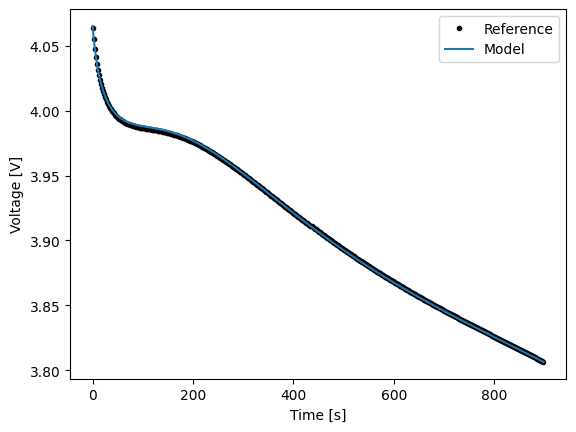

In [ ]:
# Ground truth
plt.plot(t_eval, voltage, "k.", label="Reference")

# PyBaMM solution
t = sol.t
v = sol["Battery voltage [V]"](t)

plt.plot(t, v, label="Model")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.show()

### Convergence and Parameter Trajectories

To assess the optimisation process, we can plot the convergence of the cost function and the trajectories of the parameters:

In [ ]:
pybop.plot.convergence(optim)
pybop.plot.parameters(optim);

### Cost Landscape

Finally, we can visualise the cost landscape and the path taken by the optimiser:

In [ ]:
# Plot the cost landscape with updated bounds
bounds = np.asarray([[0.6, 0.9], [0.5, 0.8]])
pybop.plot.surface(optim, bounds=bounds);

### Conclusion

This notebook illustrates how to perform parameter estimation using AdamW in PyBOP, providing insights into the optimisation process through various visualisations.